In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score

# -------------------------------
# 1. Определим функции активации
# -------------------------------
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

# -------------------------------
# 2. Класс одного нейрона
# -------------------------------
class Neuron:
    def __init__(self, input_size, lr=0.1):
        self.weights = np.random.randn(input_size, 1) * 0.01
        self.bias = 0
        self.lr = lr

    def forward(self, X):
        self.X = X
        self.Z = np.dot(X, self.weights) + self.bias
        self.A = sigmoid(self.Z)
        return self.A

    def backward(self, dA):
        dZ = dA * sigmoid_derivative(self.A)
        dW = np.dot(self.X.T, dZ) / self.X.shape[0]
        dB = np.sum(dZ) / self.X.shape[0]

        # обновление весов
        self.weights -= self.lr * dW
        self.bias -= self.lr * dB
        return dZ

# -------------------------------
# 3. Класс многослойной сети
# -------------------------------
class MLP:
    def __init__(self, layer_sizes, lr=0.1):
        self.layers = []
        self.lr = lr
        for i in range(len(layer_sizes)-1):
            layer = {
                'weights': np.random.randn(layer_sizes[i], layer_sizes[i+1]) * 0.01,
                'bias': np.zeros((1, layer_sizes[i+1]))
            }
            self.layers.append(layer)

    def forward(self, X):
        self.activations = [X]
        A = X
        for layer in self.layers:
            Z = np.dot(A, layer['weights']) + layer['bias']
            A = sigmoid(Z)
            self.activations.append(A)
        return A

    def backward(self, X, Y):
        m = X.shape[0]
        A_final = self.activations[-1]
        dA = A_final - Y  # для MSE или бинарной кросс-энтропии

        for i in reversed(range(len(self.layers))):
            A_prev = self.activations[i]
            dZ = dA * sigmoid_derivative(self.activations[i+1])
            dW = np.dot(A_prev.T, dZ) / m
            dB = np.sum(dZ, axis=0, keepdims=True) / m

            # обновляем веса
            self.layers[i]['weights'] -= self.lr * dW
            self.layers[i]['bias'] -= self.lr * dB

            dA = np.dot(dZ, self.layers[i]['weights'].T)

    def train(self, X, Y, epochs=1000):
        for _ in range(epochs):
            self.forward(X)
            self.backward(X, Y)

    def predict(self, X):
        A = self.forward(X)
        return (A > 0.5).astype(int)


In [2]:
iris = datasets.load_iris()
X = iris.data[:, :2]  # только 2 признака для визуализации
y = iris.target

# Берём только 2 класса: 0 и 1
mask = y < 2
X = X[mask]
y = y[mask].reshape(-1, 1)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
neuron = Neuron(input_size=2, lr=0.1)
for _ in range(1000):
    output = neuron.forward(X_train)
    neuron.backward(output - y_train)

y_pred_train = neuron.forward(X_train) > 0.5
y_pred_test = neuron.forward(X_test) > 0.5

print("Accuracy (1 neuron) - train:", accuracy_score(y_train, y_pred_train))
print("Accuracy (1 neuron) - test:", accuracy_score(y_test, y_pred_test))

Accuracy (1 neuron) - train: 0.9875
Accuracy (1 neuron) - test: 1.0


In [4]:
# MLP: 2 входа -> 10 -> 10 -> 1 выход
mlp = MLP([2, 10, 10, 1], lr=0.1)
mlp.train(X_train, y_train, epochs=2000)

y_pred_train_mlp = mlp.predict(X_train)
y_pred_test_mlp = mlp.predict(X_test)

print("Accuracy (MLP) - train:", accuracy_score(y_train, y_pred_train_mlp))
print("Accuracy (MLP) - test:", accuracy_score(y_test, y_pred_test_mlp))

Accuracy (MLP) - train: 0.525
Accuracy (MLP) - test: 0.4


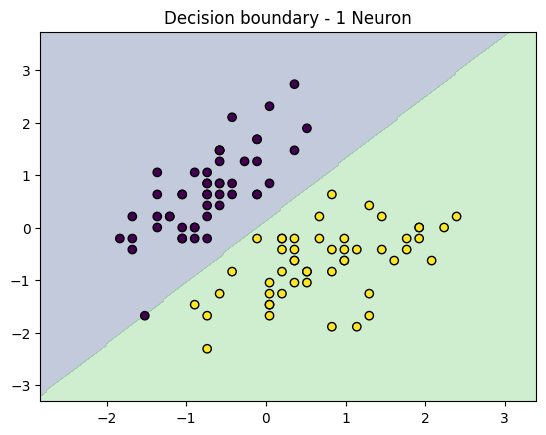

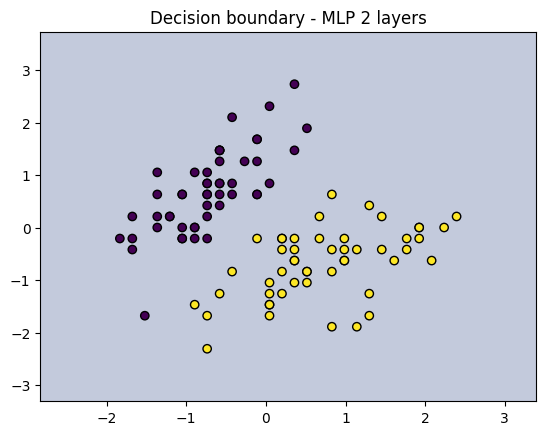

In [5]:
def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    if isinstance(model, Neuron):
        Z = model.forward(grid) > 0.5
    else:
        Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:,0], X[:,1], c=y.ravel(), edgecolors='k')
    plt.title(title)
    plt.show()

plot_decision_boundary(neuron, X, y, "Decision boundary - 1 Neuron")
plot_decision_boundary(mlp, X, y, "Decision boundary - MLP 2 layers")